In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from statistics import mean
import joblib
from utils import *
sns.set_theme()

In [2]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")

In [3]:
for col in stateless_df.columns:
    print(f"Percentage of missing values in {col} : {stateless_df[col].isna().sum()/stateless_df.shape[0]}")

Percentage of missing values in timestamp : 0.0
Percentage of missing values in FQDN_count : 0.0
Percentage of missing values in subdomain_length : 0.0
Percentage of missing values in upper : 0.0
Percentage of missing values in lower : 0.0
Percentage of missing values in numeric : 0.0
Percentage of missing values in entropy : 0.0
Percentage of missing values in special : 0.0
Percentage of missing values in labels : 0.0
Percentage of missing values in labels_max : 0.0
Percentage of missing values in labels_average : 0.0
Percentage of missing values in longest_word : 4.093971165236638e-05
Percentage of missing values in sld : 0.0
Percentage of missing values in len : 0.0
Percentage of missing values in subdomain : 0.0
Percentage of missing values in original_index : 0.0
Percentage of missing values in data_type : 0.0
Percentage of missing values in attack : 0.0
Percentage of missing values in origin : 0.0


In [4]:
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

D:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.7528806407733654
Test Accuracy: 0.7526131944031748
Total time elapsed for prediction: 0.61


D:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.756899081993301
Test Accuracy: 0.7367242904874474
Total time elapsed for prediction: 0.56


D:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.7504296192112835
Test Accuracy: 0.7623314536258106
Total time elapsed for prediction: 0.63


D:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.7500301269956039
Test Accuracy: 0.7637115199218183
Total time elapsed for prediction: 0.63


D:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.753988731678247
Test Accuracy: 0.7480157420002377
Total time elapsed for prediction: 0.59


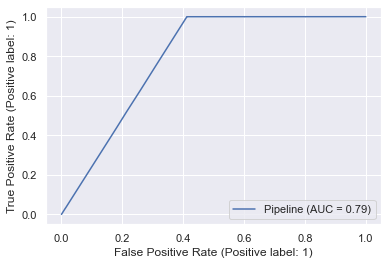

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (67704,).

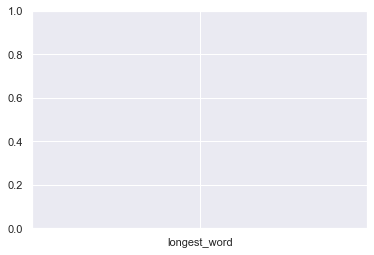

In [5]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]
y = stateless_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=300))
    ])    
    pipe.fit(X_train, y_train)
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += (prediction_time_end - prediction_time_start)
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
#importance = pipe["lr"].coef_[0]

# plt.bar([stateless_df.columns if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]], importance)
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.show()

In [14]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 3.033
Time to evaluate a single data point: 0.00000400


## Overall Results

In [15]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999055,0.595960,0.746572,462858.000000
1,0.611284,0.999113,0.758499,294353.000000
accuracy,0.752679,0.752679,0.752679,0.752679
macro avg,0.805170,0.797537,0.752536,757211.000000
weighted avg,0.848316,0.752679,0.751209,757211.000000


## Light-attack

In [16]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999535,0.608660,0.756596,60091.000000
1,0.644677,0.999602,0.783833,42683.000000
accuracy,0.771022,0.771022,0.771022,0.771022
macro avg,0.822106,0.804131,0.770215,102774.000000
weighted avg,0.852159,0.771022,0.767908,102774.000000


## Heavy-attack

In [17]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.997772,0.601429,0.750486,181694.00000
1,0.776380,0.999030,0.873744,251670.00000
accuracy,0.832330,0.832330,0.832330,0.83233
macro avg,0.887076,0.800230,0.812115,433364.00000
weighted avg,0.869202,0.832330,0.822066,433364.00000


In [18]:
stateless_df.Predictions.value_counts(normalize=False)

1    481105
0    276106
Name: Predictions, dtype: int64

# Stateful Model Reimplementation

In [19]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Train Accuracy: 0.7969897560138113
Test Accuracy: 0.805268880792049
Total time elapsed for prediction: 0.33
Train Accuracy: 0.8012485454302665
Test Accuracy: 0.7882527994506019
Total time elapsed for prediction: 0.34
Train Accuracy: 0.7975715839072127
Test Accuracy: 0.8029606455428168
Total time elapsed for prediction: 0.43
Train Accuracy: 0.798234486179203
Test Accuracy: 0.8003090364548558
Total time elapsed for prediction: 0.38
Train Accuracy: 0.7992121478033613
Test Accuracy: 0.7964174662825967
Total time elapsed for prediction: 0.32


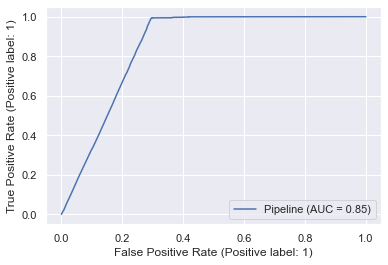

In [22]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=500))
    ])
    
    pipe.fit(X_train, y_train)
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateful_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateful += (prediction_time_end - prediction_time_start)
    
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    #display(pd.DataFrame(classification_report(y_test, pipe.predict(X_test), output_dict=True)).T)
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
# importance = pipe["lr"].coef_[0]

# plt.bar([col for col in X.columns], importance)
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.show()

In [23]:
print(f"Total prediction time for {stateful_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateful_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")

Total prediction time for 262105 rows is 1.793
Time to evaluate a single data point: 0.00000684


## Overall Results

In [24]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.993352,0.709546,0.827799,178782.000000
1,0.613637,0.989811,0.757598,83323.000000
accuracy,0.798642,0.798642,0.798642,0.798642
macro avg,0.803494,0.849678,0.792698,262105.000000
weighted avg,0.872641,0.798642,0.805482,262105.000000


## Light Attack Results

In [25]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.994598,0.711657,0.829668,22768.000000
1,0.630599,0.992209,0.771115,11295.000000
accuracy,0.804685,0.804685,0.804685,0.804685
macro avg,0.812598,0.851933,0.800391,34063.000000
weighted avg,0.873899,0.804685,0.810252,34063.000000


## Heavy Attack Results

In [26]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.984686,0.709010,0.824412,69016.000000
1,0.780153,0.989435,0.872419,72028.000000
accuracy,0.852216,0.852216,0.852216,0.852216
macro avg,0.882420,0.849222,0.848415,141044.000000
weighted avg,0.880236,0.852216,0.848928,141044.000000


In [27]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

# Two-step model

In [28]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7

In [29]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)
    print(f"Within this time, at least {exfiltration_data_size(estimated_time, stateless_df_subset, is_light=is_light):.6f} MB of data could have been exfiltrated")

## Light attack

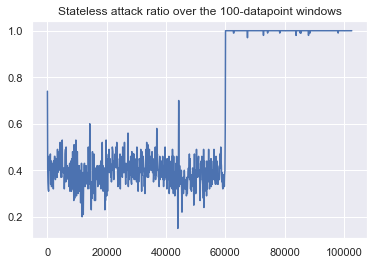

,precision,recall,f1-score,support
0,1.000000,0.946897,0.972724,60091.000000
1,0.930440,1.000000,0.963967,42683.000000
accuracy,0.968951,0.968951,0.968951,0.968951
macro avg,0.965220,0.973449,0.968346,102774.000000
weighted avg,0.971111,0.968951,0.969087,102774.000000


Total Estimated Time:  0.6038997575930324
2.1421067989495186
Within this time, at least 0.001046 MB of data could have been exfiltrated


In [30]:
two_step(stateless_df, stateful_df, is_light=True)

## Heavy attack

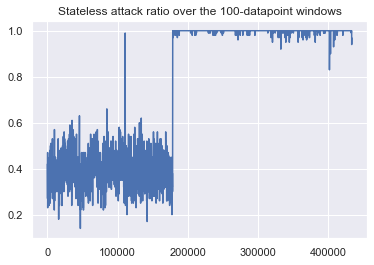

,precision,recall,f1-score,support
0,1.000000,0.928484,0.962916,181694.000000
1,0.950904,1.000000,0.974834,251670.000000
accuracy,0.970016,0.970016,0.970016,0.970016
macro avg,0.975452,0.964242,0.968875,433364.000000
weighted avg,0.971488,0.970016,0.969837,433364.000000


Total Estimated Time:  2.259655900476174
9.714067963776563
Within this time, at least 0.012050 MB of data could have been exfiltrated


In [31]:
two_step(stateless_df, stateful_df, is_light=False)

Some potentially useful libraries we could use:
https://github.com/irvinhomem/TunnelFeatureExtractor
https://github.com/lucadivit/Pcap_Features_Extraction

# Saving the stateless and stateful models by training on all the data, in order to evaluate on the robustness queries:

## Stateless

In [39]:



X = stateless_df[[col for col in stateless_df.columns if col not in ["timestamp", "attack", "origin", "data_type", "original_index", "Predictions"]]]
y = stateless_df["attack"]



category_pipeline = ColumnTransformer(
[
 #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"), ["longest_word", "sld"]),
 ('scaler', StandardScaler(), [col for col in X if col not in ["longest_word", "sld"]])
 ]
)

pipe = Pipeline([
    ('lr', LogisticRegression(random_state=0, max_iter=500))
])    
pipe.fit(category_pipeline.fit_transform(X), y)
joblib.dump(category_pipeline, "lr_baseline_column_transformer.pkl")
joblib.dump(pipe, 'lr_baseline_model.pkl')



D:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['lr_baseline_model.pkl']